In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (GridSearchCV, ParameterGrid,
                                     RandomizedSearchCV)
from sklearn.metrics import fbeta_score, make_scorer
from imblearn.pipeline import Pipeline as Pipeline_imb
from imblearn.over_sampling import SMOTENC, RandomOverSampler
from tools import (COLUMNS_QUANT, COLUMNS_CAT,
                   Modelisation, datasets, SearchCV, restauration_CV, 
                   graph_2scores_CV, graph_3scores_CV, graph_param_CV, 
                   best_score_CV)

## Matplotlib : 
# Pour affichage interactif (notamment 3D) dans notebook
# %matplotlib widget

# Pour affichage interactif (notamment 3D) dans une fenêtre qt externe au notebook
# %matplotlib qt

# Pour affichage simple dans notebook
# %config InlineBackend.figure_format = 'png'

t = time.time()

In [2]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df.shape

(1610494, 48)

**Définition des variables quantitatives, des variables catégorielles et des datasets :**

In [3]:
datasets_df = datasets(df)
X_quant = datasets_df['X_quant']
X_cat = datasets_df['X_cat']
X = datasets_df['X']
y = datasets_df['y']

Columns_quant :


['contextid',
 'campaignctrlast24h',
 'dayssincelastvisitdouble',
 'ltf_nbglobaldisplay_4w',
 'ltf_nbpartnerdisplayssincelastclick',
 'ltf_nbpartnerdisplay_90d',
 'ltf_nbpartnerclick_90d',
 'ltf_nbpartnersales_90d',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'display_size',
 'zonecostineuro']


Columns_cat :


['display_env',
 'target_env',
 'campaignscenario',
 'campaignvertical',
 'is_interstitial',
 'device_type',
 'hour',
 'weekday']


Nombre de variables pour X_quant : 13



Index(['contextid', 'campaignctrlast24h', 'dayssincelastvisitdouble',
       'ltf_nbglobaldisplay_4w', 'ltf_nbpartnerdisplayssincelastclick',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplayglobalapprox_1d_sum_xdevice', 'display_size',
       'zonecostineuro'],
      dtype='object')


Nombre de variables pour X_cat : 50



Index(['display_env_app_ios', 'display_env_other', 'display_env_web',
       'target_env_2', 'campaignscenario_5', 'campaignscenario_6',
       'campaignscenario_11', 'campaignscenario_12', 'campaignscenario_13',
       'campaignscenario_17', 'campaignvertical_20.0', 'campaignvertical_23.0',
       'campaignvertical_129.0', 'campaignvertical_200002.0',
       'is_interstitial_True', 'device_type_Desktop',
       'device_type_Desktop - Safari', 'device_type_Mobile - Other',
       'device_type_Unknown', 'device_type_iPad', 'device_type_iPhone',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday'],
      dtype='object')


Nombre de variables pour X : 63


Afin de comparer nos modèles en termes de performances brutes et de temps d'exécution, il est fondamental de déterminer quelques métriques de référence. Ici, il faut surtout faire en sorte d'éviter de prédire des non-clics qui seraient en réalité des clics (ie prédire trop de 0), quitte à prédire trop de 1. Autrement dit, il faut maximiser le recall et le NPV (Negative predictive value) afin de limiter les erreurs de type II. Le F1 Score, combinaison du recall et de la précision, est également pertinent. 

# Régression logistique
## Variables quantitatives

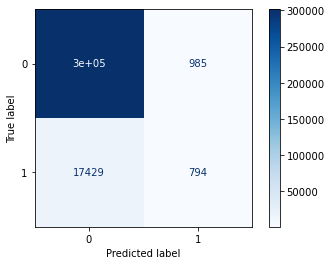

f1 : 0.0794
f3 : 0.0479
f5 : 0.0451
recall : 0.0436
negative predictive value : 0.9454
precision : 0.4463
roc_auc : 0.7421
training time : 1.869s
prediction time : 0.01s


In [4]:
m = Modelisation(X_quant, y, LogisticRegression(), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

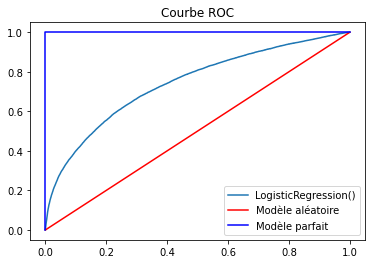

In [5]:
m.show_ROC()

In [6]:
coeff_df = pd.DataFrame(np.transpose(m.model.coef_), X_quant.columns, columns=['Coefficient'])
coeff_df

,Coefficient
contextid,-0.028407
campaignctrlast24h,0.361237
dayssincelastvisitdouble,-0.026081
ltf_nbglobaldisplay_4w,0.015844
ltf_nbpartnerdisplayssincelastclick,-0.024294
ltf_nbpartnerdisplay_90d,-0.017358
ltf_nbpartnerclick_90d,0.038549
ltf_nbpartnersales_90d,-0.010389
nbdayssincelastclick,-0.111413
nbdisplay_1hour,-0.219563


**Problème :** pas de scaling dans la cellule suivante

In [7]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant

X_quant_scaled = datasets_df['X_quant_scaled']
X_ = add_constant(X_quant_scaled)
print(Logit(y, X_).fit().summary())

Optimization terminated successfully.
         Current function value: 0.197291
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:     is_display_clicked   No. Observations:              1603554
Model:                          Logit   Df Residuals:                  1603540
Method:                           MLE   Df Model:                           13
Date:                Sun, 14 Mar 2021   Pseudo R-squ.:                 0.09816
Time:                        18:49:05   Log-Likelihood:            -3.1637e+05
converged:                       True   LL-Null:                   -3.5080e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0392      0.004   -760.154      0.000      -3.047      -3.031
x1            -0.0256      0.

Avec LASSO (+ univariate mais variable déjà exclue par Lasso): 

In [8]:
X1 = df[['contextid',
         'zonecostineuro',
         'campaignctrlast24h',
         'ltf_nbpartnerclick_90d',
         'nbdisplay_1hour',
         'nbdayssincelastclick',
         'display_size',
         'nbdisplayglobalapprox_1d_sum_xdevice']]
y1 = df['is_display_clicked']

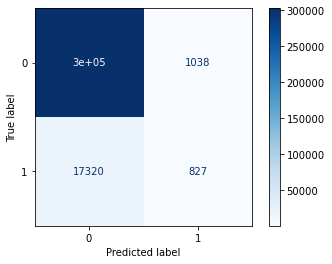

f1 : 0.0827
f3 : 0.0501
f5 : 0.0472
recall : 0.0456
negative predictive value : 0.9459
precision : 0.4434
roc_auc : 0.7384
training time : 1.637s
prediction time : 0.022s


In [9]:
m1 = Modelisation(X1, y1, LogisticRegression(), scaling=True)
m1.show_conf_matrix()
m1.show_metrics_score()

## Variables catégorielles

In [10]:
# Nombre de valeurs distinctes
from tools import COLUMNS_CAT
for column in COLUMNS_CAT:
    print(f"{column} : {len(set(df[column]))}")

display_env : 4
target_env : 2
campaignscenario : 7
campaignvertical : 34
is_interstitial : 3
device_type : 7
hour : 24
weekday : 7


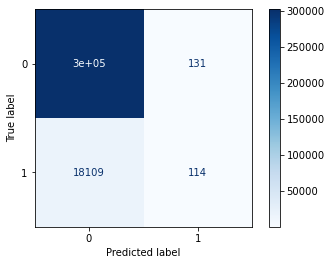

f1 : 0.0123
f3 : 0.0069
f5 : 0.0065
recall : 0.0063
negative predictive value : 0.9435
precision : 0.4653
roc_auc : 0.6941
training time : 6.241s
prediction time : 0.025s


In [11]:
m = Modelisation(X_cat, y, LogisticRegression(), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

## Variables quantitatives + catégorielles

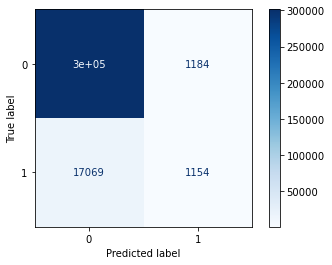

f1 : 0.1123
f3 : 0.0694
f5 : 0.0655
recall : 0.0633
negative predictive value : 0.9464
precision : 0.4936
roc_auc : 0.7616
training time : 7.504s
prediction time : 0.033s


In [12]:
m = Modelisation(X, y, LogisticRegression(), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

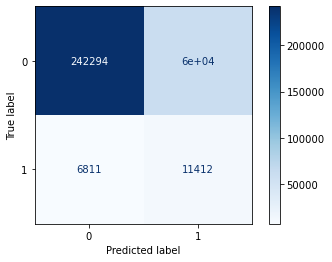

f1 : 0.2541
f3 : 0.4844
f5 : 0.5628
recall : 0.6262
negative predictive value : 0.9727
precision : 0.1594
roc_auc : 0.7823
training time : 6.462s
prediction time : 0.034s


In [13]:
m = Modelisation(X, y, LogisticRegression(class_weight='balanced'), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

Avec RFECV :

In [14]:
X2 = X[['zonecostineuro',
         'campaignctrlast24h',
         'nbdisplay_1hour',
         'nbdayssincelastclick',
         'display_size',
         'is_interstitial_True',
         'device_type_Desktop',
         'device_type_iPhone',
         'display_env_app_ios',
         'target_env_2',
         'campaignscenario_13']]

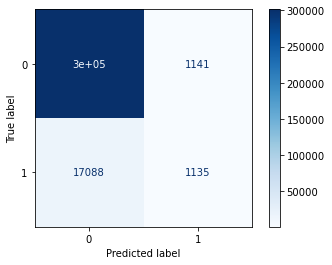

f1 : 0.1107
f3 : 0.0683
f5 : 0.0645
recall : 0.0623
negative predictive value : 0.9463
precision : 0.4987
roc_auc : 0.7576
training time : 2.086s
prediction time : 0.018s


In [15]:
m2 = Modelisation(X2, y, LogisticRegression(), scaling=True)
m2.show_conf_matrix()
m2.show_metrics_score()

## Comparaison par rapport aux valeurs de C 

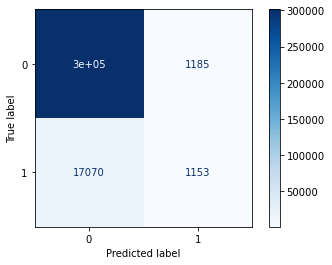

f1 : 0.1122
f3 : 0.0693
f5 : 0.0655
recall : 0.0633
negative predictive value : 0.9464
precision : 0.4932
roc_auc : 0.7616
training time : 6.939s
prediction time : 0.029s


In [16]:
m = Modelisation(X, y, LogisticRegression(C=0.2), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

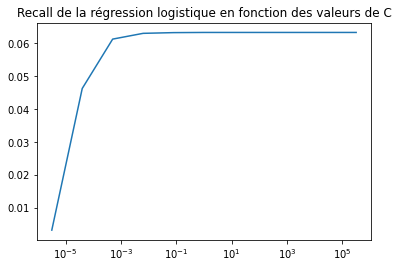

CPU times: user 20min 55s, sys: 36min 58s, total: 57min 53s
Wall time: 1min 53s


In [17]:
%%time
C, list_recall = [], []
for c in np.logspace(-5.5, 5.5, num=11): 
    m = Modelisation(X, y, LogisticRegression(C=c), scaling=True)
    C.append(c)
    list_recall.append(m.recall)
plt.plot(C, list_recall)
plt.xscale('log')
plt.title("Recall de la régression logistique en fonction des valeurs de C")
plt.show()

## Tuning des hyperparamètres avec GridSearchCV

In [18]:
model = LogisticRegression()

cv_params = {
        "C": np.logspace(-6, 2, 30),
        "class_weight": [None, 'balanced', {0:1, 1:2}, {0:1, 1:4}, {0:1, 1:8}, {0:1, 1:10}, {0:1, 1:12}, {0:1, 1:14}, {0:1, 1:16.5}, {0:1, 1:32}] 
        }

scoring = {'recall': 'recall',
           'precision': 'precision',
           'f1': 'f1',
           'f3': make_scorer(fbeta_score, beta=3),
           'f5': make_scorer(fbeta_score, beta=5)
          }

print(len(ParameterGrid(cv_params)))

300


In [19]:
# SearchCV(model, cv_params, data_frac=1, scaling=True, scoring=scoring, n_jobs=28)

In [20]:
dico, results = restauration_CV('LR_CV_Grid_300_1')

model : LogisticRegression()
model_name : LR
type : GridSearchCV
len_grid : 300
data_frac : 1
temps : 00:19:54
n_jobs : 28
params : {'C': array([1.00000000e-06, 1.88739182e-06, 3.56224789e-06, 6.72335754e-06,
       1.26896100e-05, 2.39502662e-05, 4.52035366e-05, 8.53167852e-05,
       1.61026203e-04, 3.03919538e-04, 5.73615251e-04, 1.08263673e-03,
       2.04335972e-03, 3.85662042e-03, 7.27895384e-03, 1.37382380e-02,
       2.59294380e-02, 4.89390092e-02, 9.23670857e-02, 1.74332882e-01,
       3.29034456e-01, 6.21016942e-01, 1.17210230e+00, 2.21221629e+00,
       4.17531894e+00, 7.88046282e+00, 1.48735211e+01, 2.80721620e+01,
       5.29831691e+01, 1.00000000e+02]), 'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 4}, {0: 1, 1: 8}, {0: 1, 1: 10}, {0: 1, 1: 12}, {0: 1, 1: 14}, {0: 1, 1: 16.5}, {0: 1, 1: 32}]}
scoring : {'recall': 'recall', 'precision': 'precision', 'f1': 'f1', 'f3': make_scorer(fbeta_score, beta=3), 'f5': make_scorer(fbeta_score, beta=5)}


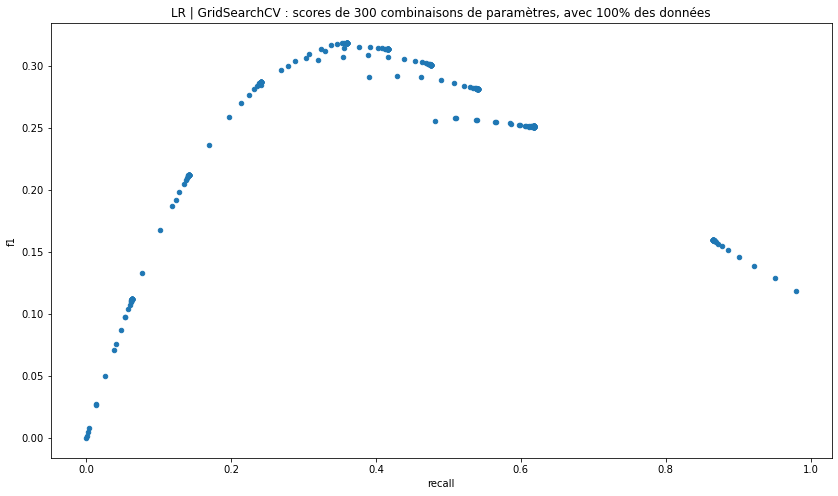

In [21]:
graph_2scores_CV(dico, results, 'recall', 'f1', s=20)

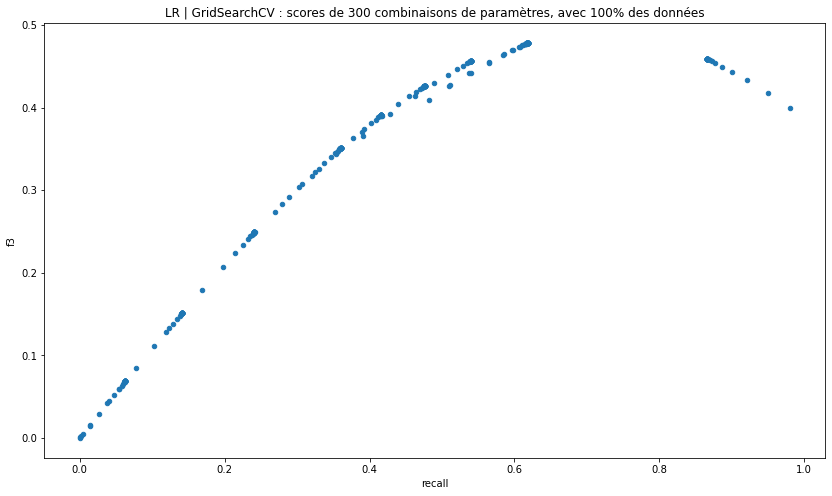

In [22]:
graph_2scores_CV(dico, results, 'recall', 'f3', s=20)

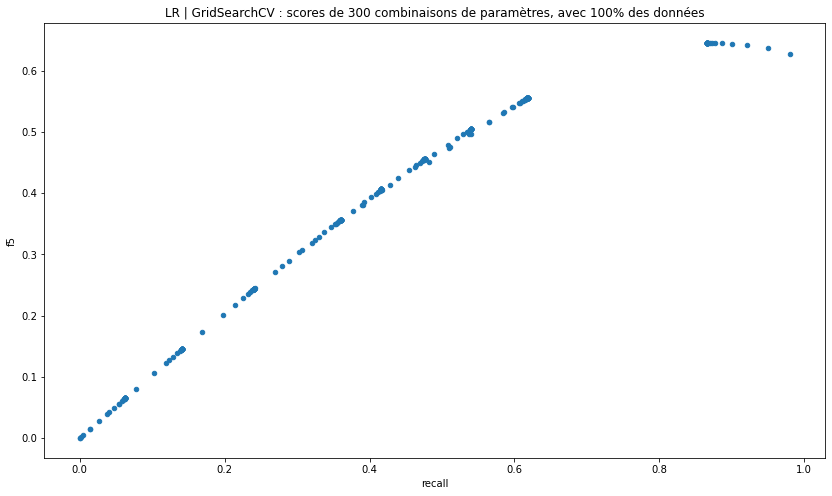

In [23]:
graph_2scores_CV(dico, results, 'recall', 'f5', s=20)

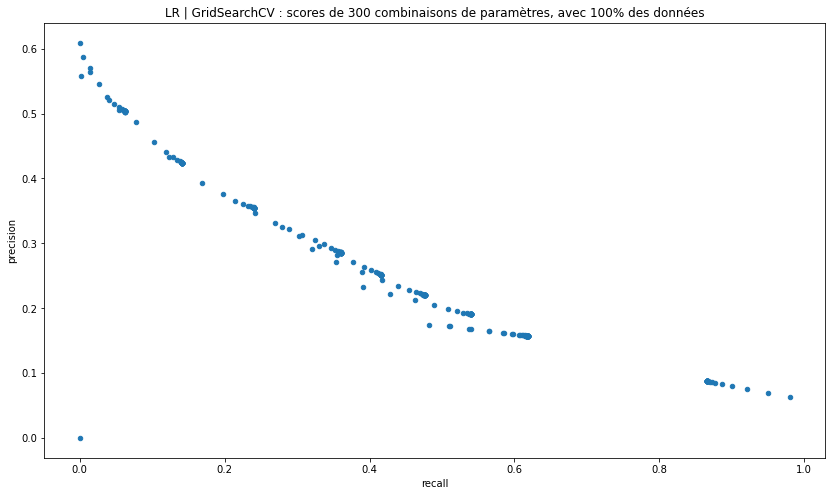

In [24]:
graph_2scores_CV(dico, results, 'recall', 'precision', s=20)

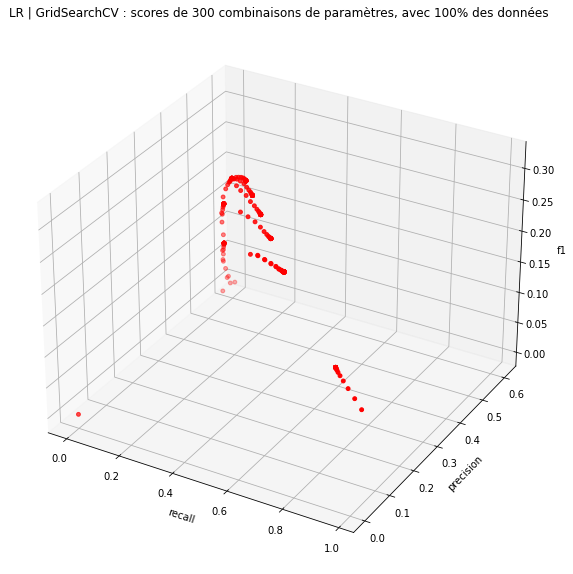

In [25]:
graph_3scores_CV(dico, results, 'recall', 'precision', 'f1', s=15)

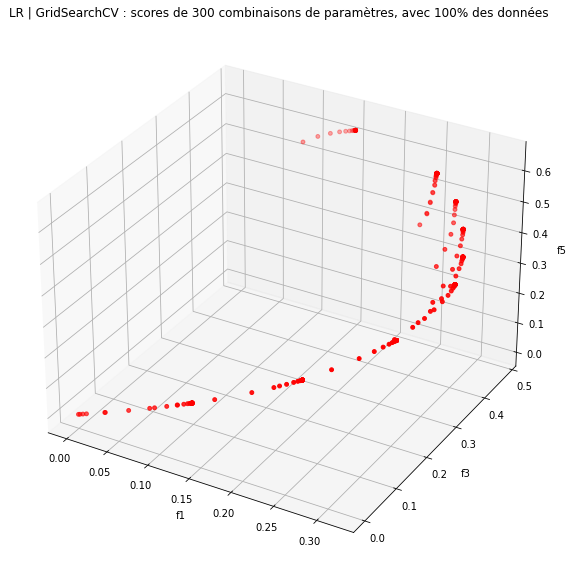

In [26]:
graph_3scores_CV(dico, results, 'f1', 'f3', 'f5', s=15)

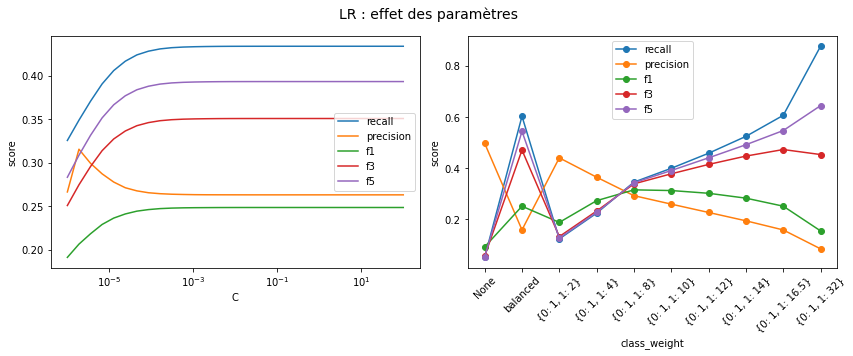

In [27]:
graph_param_CV(dico, results, xscale={'C': 'log'}, ncols=2, height=5, width=6)

In [28]:
best_params = best_score_CV(dico, results, 'f3')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,params,mean_test_recall,std_test_recall,rank_test_recall,...,rank_test_precision,mean_test_f1,std_test_f1,rank_test_f1,mean_test_f3,std_test_f3,rank_test_f3,mean_test_f5,std_test_f5,rank_test_f5
281,23.603975,0.424289,1.267619,0.122257,52.983169,balanced,"{'C': 52.98316906283702, 'class_weight': 'bala...",0.618597,0.004566,31,...,258,0.251002,0.001405,191,0.478455,0.003152,1,0.555964,0.003899,31
261,25.572857,1.84721,1.327648,0.105604,14.873521,balanced,"{'C': 14.873521072935118, 'class_weight': 'bal...",0.618597,0.004566,31,...,258,0.251002,0.001405,191,0.478455,0.003152,1,0.555964,0.003899,31
291,22.541212,1.373823,1.214874,0.140763,100.0,balanced,"{'C': 100.0, 'class_weight': 'balanced'}",0.618597,0.004566,31,...,258,0.251002,0.001405,191,0.478455,0.003152,1,0.555964,0.003899,31
231,22.69218,0.862041,1.292479,0.073772,2.212216,balanced,"{'C': 2.21221629107045, 'class_weight': 'balan...",0.618597,0.004566,31,...,258,0.251002,0.001405,191,0.478455,0.003152,1,0.555964,0.003899,31
271,22.578504,0.849444,1.246491,0.146737,28.072162,balanced,"{'C': 28.072162039411758, 'class_weight': 'bal...",0.618597,0.004566,31,...,258,0.251002,0.001405,191,0.478455,0.003152,1,0.555964,0.003899,31
241,23.757304,0.368637,1.325371,0.167128,4.175319,balanced,"{'C': 4.175318936560401, 'class_weight': 'bala...",0.618597,0.004566,31,...,258,0.251002,0.001405,191,0.478455,0.003152,1,0.555964,0.003899,31
251,22.378671,2.153017,1.330958,0.021784,7.880463,balanced,"{'C': 7.880462815669905, 'class_weight': 'bala...",0.618597,0.004566,31,...,258,0.251002,0.001405,191,0.478455,0.003152,1,0.555964,0.003899,31
171,24.330094,0.382302,1.340492,0.175269,0.048939,balanced,"{'C': 0.04893900918477489, 'class_weight': 'ba...",0.618586,0.004574,38,...,257,0.251001,0.001404,198,0.478449,0.003154,8,0.555956,0.003904,38
201,22.637013,0.733843,1.209076,0.086798,0.329034,balanced,"{'C': 0.3290344562312671, 'class_weight': 'bal...",0.618586,0.004574,38,...,265,0.251,0.001405,199,0.478448,0.003155,9,0.555955,0.003905,39
191,23.687094,0.879318,1.253099,0.13124,0.174333,balanced,"{'C': 0.17433288221999874, 'class_weight': 'ba...",0.618586,0.004574,38,...,267,0.250999,0.001406,200,0.478448,0.003157,10,0.555955,0.003905,40


Meilleure combinaison de paramètres pour f3 :


{'C': 52.98316906283702, 'class_weight': 'balanced'}

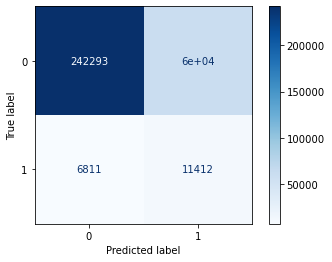

f1 : 0.2541
f3 : 0.4844
f5 : 0.5628
recall : 0.6262
negative predictive value : 0.9727
precision : 0.1594
roc_auc : 0.7823
training time : 6.33s
prediction time : 0.033s


In [29]:
m = Modelisation(X, y, LogisticRegression(**best_params), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

## Régression logistique avec sur-échantillonnage

**/!\ : Seule la base de training est sur-échantillonnée.**

In [30]:
len(y[y == 1]) / (len(y[y == 0]))

0.06049828183239467

In [31]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=0.05)
df.shape

(80525, 48)

In [32]:
datasets_df = datasets(df, verbose=False)
X = datasets_df['X']
y = datasets_df['y']

In [33]:
categorical_features = list(range(len(COLUMNS_QUANT), len(X.columns)))
print(categorical_features)

over = SMOTENC(categorical_features=categorical_features, 
              sampling_strategy=1, 
              k_neighbors=5,
              random_state=1234)

pipeline = Pipeline_imb([
            ('over', over),
            ('model', LogisticRegression())
            ])

[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]


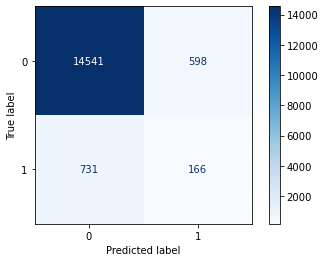

f1 : 0.1999
f3 : 0.1878
f5 : 0.1861
recall : 0.1851
negative predictive value : 0.9521
precision : 0.2173
roc_auc : 0.6886
training time : 54.683s
prediction time : 0.006s


In [34]:
m = Modelisation(X, y, pipeline, scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

In [35]:
over = RandomOverSampler(sampling_strategy=1, random_state=1234)

pipeline = Pipeline_imb([
            ('over', over),
            ('model', LogisticRegression())
            ])

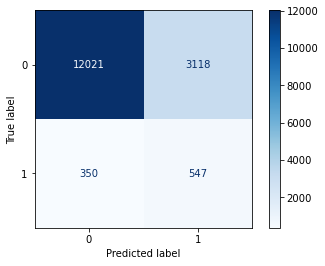

f1 : 0.2398
f3 : 0.4660
f5 : 0.5451
recall : 0.6098
negative predictive value : 0.9717
precision : 0.1492
roc_auc : 0.7672
training time : 0.978s
prediction time : 0.017s


In [36]:
m = Modelisation(X, y, pipeline, scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

### GridSearchCV avec RandomOverSampler

In [37]:
over = RandomOverSampler(random_state=1234)

pipeline = Pipeline_imb([
            ('over', over),
            ('model', LogisticRegression())
            ])

cv_params = {
        "over__sampling_strategy": [0.1, 0.2, 0.4, 0.6, 0.8, 1],
        "model__C": np.logspace(-6, 2, 30),
        "model__class_weight": [None, 'balanced', {0:1, 1:2}, {0:1, 1:4}, {0:1, 1:8}, {0:1, 1:10}, {0:1, 1:12}, {0:1, 1:14}, {0:1, 1:16.5}, {0:1, 1:32}] 
        }

scoring = {'recall': 'recall',
           'precision': 'precision',
           'f1': 'f1',
           'f3': make_scorer(fbeta_score, beta=3),
           'f5': make_scorer(fbeta_score, beta=5)
          }

print(len(ParameterGrid(cv_params)))

1800


In [38]:
# SearchCV(pipeline, cv_params, data_frac=1, scaling=True, scoring=scoring, n_jobs=28)

In [39]:
dico, results = restauration_CV('RandomOver_LR_CV_Grid_1800_1')

model : Pipeline(steps=[('over', RandomOverSampler(random_state=1234)),
                ('model', LogisticRegression())])
model_name : RandomOver_LR
type : GridSearchCV
len_grid : 1800
data_frac : 1
temps : 03:27:39
n_jobs : 28
params : {'over__sampling_strategy': [0.1, 0.2, 0.4, 0.6, 0.8, 1], 'model__C': array([1.00000000e-06, 1.88739182e-06, 3.56224789e-06, 6.72335754e-06,
       1.26896100e-05, 2.39502662e-05, 4.52035366e-05, 8.53167852e-05,
       1.61026203e-04, 3.03919538e-04, 5.73615251e-04, 1.08263673e-03,
       2.04335972e-03, 3.85662042e-03, 7.27895384e-03, 1.37382380e-02,
       2.59294380e-02, 4.89390092e-02, 9.23670857e-02, 1.74332882e-01,
       3.29034456e-01, 6.21016942e-01, 1.17210230e+00, 2.21221629e+00,
       4.17531894e+00, 7.88046282e+00, 1.48735211e+01, 2.80721620e+01,
       5.29831691e+01, 1.00000000e+02]), 'model__class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 4}, {0: 1, 1: 8}, {0: 1, 1: 10}, {0: 1, 1: 12}, {0: 1, 1: 14}, {0: 1, 1: 16.5}, {0: 1, 1:

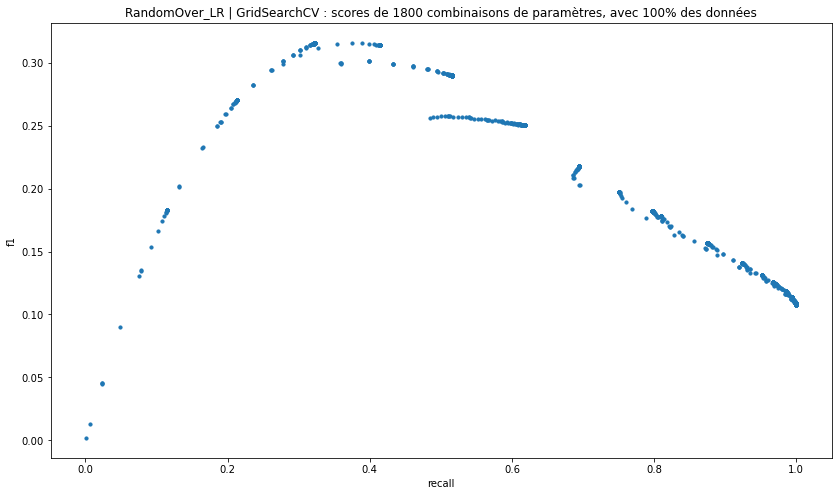

In [40]:
graph_2scores_CV(dico, results, 'recall', 'f1', s=10)

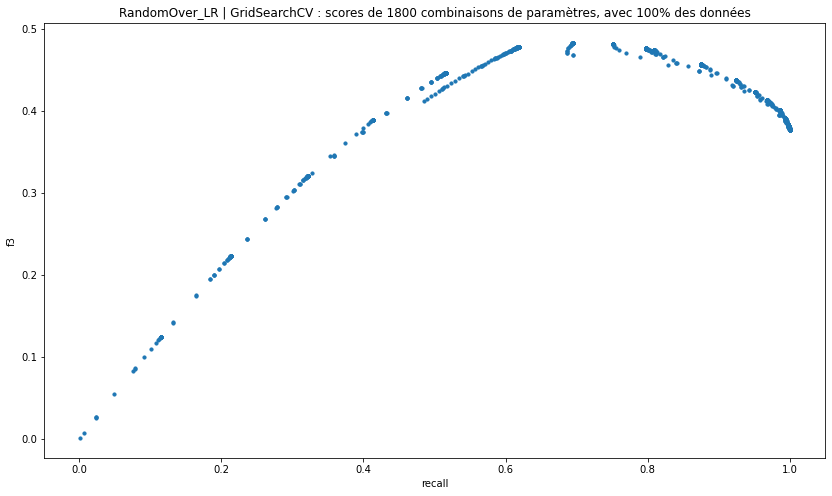

In [41]:
graph_2scores_CV(dico, results, 'recall', 'f3', s=10)

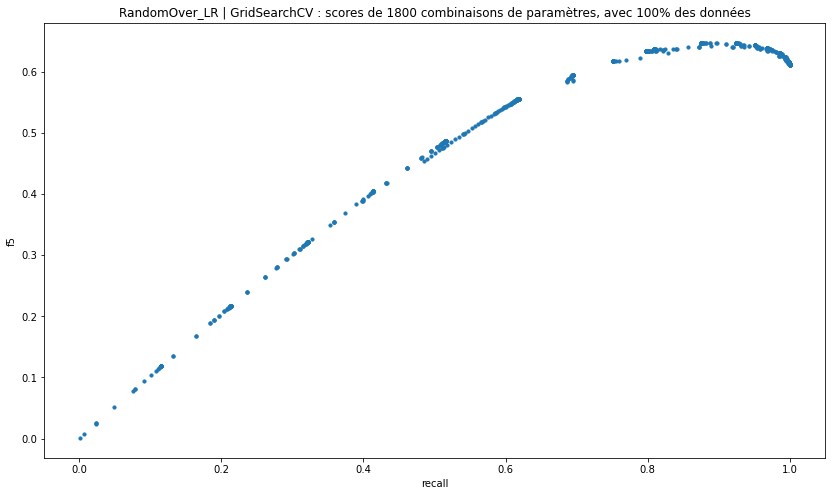

In [42]:
graph_2scores_CV(dico, results, 'recall', 'f5', s=10)

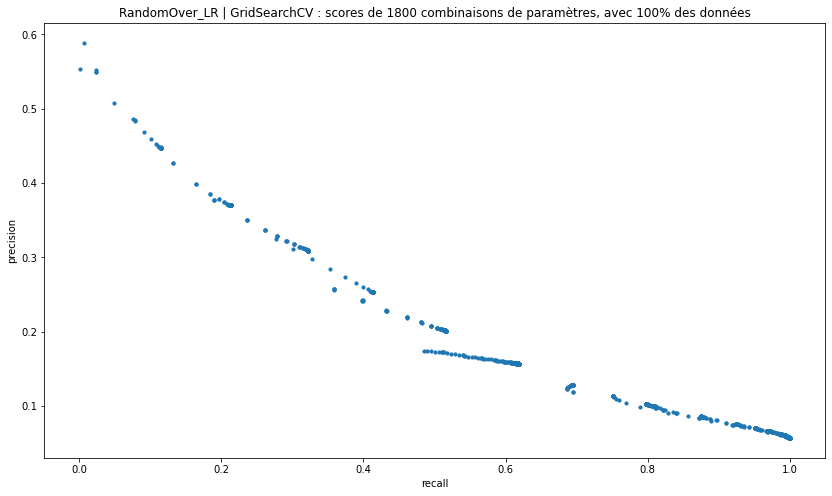

In [43]:
graph_2scores_CV(dico, results, 'recall', 'precision', s=10)

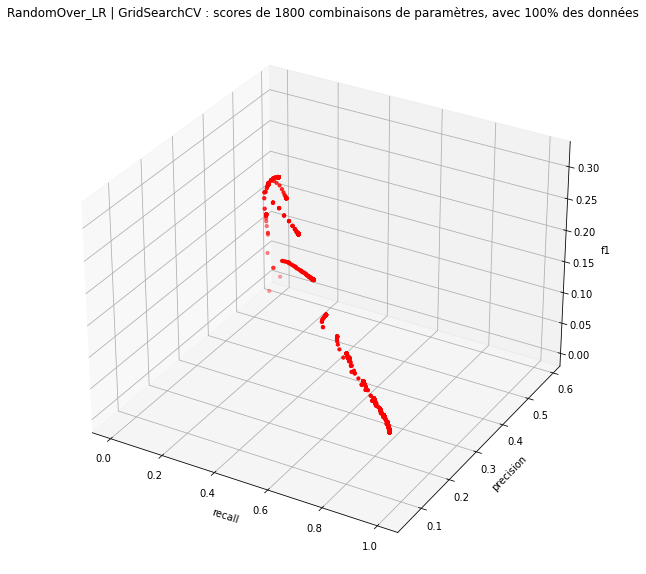

In [44]:
graph_3scores_CV(dico, results, 'recall', 'precision', 'f1', s=10)

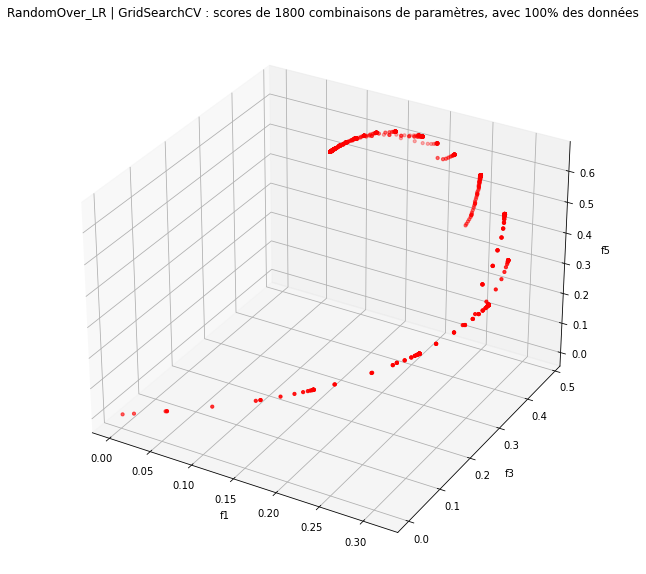

In [45]:
graph_3scores_CV(dico, results, 'f1', 'f3', 'f5', s=10)

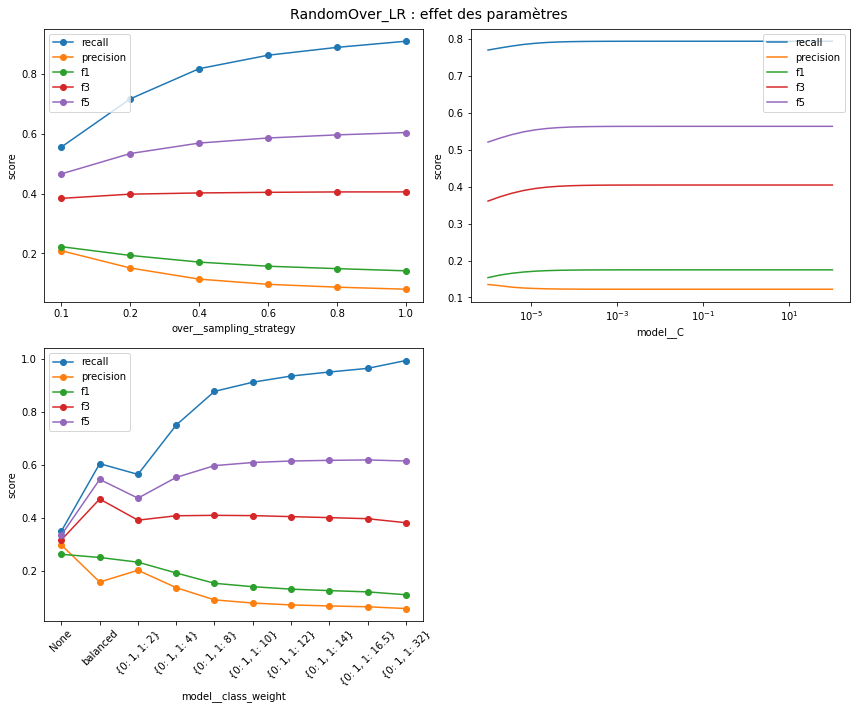

In [46]:
graph_param_CV(dico, results, xscale={'model__C': 'log'}, ncols=2, height=5, width=6)

In [47]:
best_params = best_score_CV(dico, results, 'f3')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__class_weight,param_over__sampling_strategy,params,mean_test_recall,std_test_recall,...,rank_test_precision,mean_test_f1,std_test_f1,rank_test_f1,mean_test_f3,std_test_f3,rank_test_f3,mean_test_f5,std_test_f5,rank_test_f5
1596,36.78746,2.212656,1.554558,0.242849,14.873521,"{0: 1, 1: 12}",0.1,"{'model__C': 14.873521072935118, 'model__class...",0.694637,0.003246,...,571,0.217683,0.00092,535,0.482985,0.001872,1,0.594446,0.002495,1171
1776,25.323031,7.586075,1.216163,0.224599,100.0,"{0: 1, 1: 12}",0.1,"{'model__C': 100.0, 'model__class_weight': {0:...",0.694637,0.003246,...,571,0.217683,0.00092,535,0.482985,0.001872,1,0.594446,0.002495,1171
1536,36.443997,4.763397,1.538563,0.369756,7.880463,"{0: 1, 1: 12}",0.1,"{'model__C': 7.880462815669905, 'model__class_...",0.694637,0.003246,...,571,0.217683,0.00092,535,0.482985,0.001872,1,0.594446,0.002495,1171
1476,30.437059,7.122677,1.422274,0.434596,4.175319,"{0: 1, 1: 12}",0.1,"{'model__C': 4.175318936560401, 'model__class_...",0.694637,0.003246,...,571,0.217683,0.00092,535,0.482985,0.001872,1,0.594446,0.002495,1171
1656,27.644316,7.982356,1.371431,0.224958,28.072162,"{0: 1, 1: 12}",0.1,"{'model__C': 28.072162039411758, 'model__class...",0.694637,0.003246,...,571,0.217683,0.00092,535,0.482985,0.001872,1,0.594446,0.002495,1171
1716,28.360089,7.338712,1.556202,0.287329,52.983169,"{0: 1, 1: 12}",0.1,"{'model__C': 52.98316906283702, 'model__class_...",0.694637,0.003246,...,571,0.217683,0.00092,535,0.482985,0.001872,1,0.594446,0.002495,1171
1416,33.99205,4.614376,1.45772,0.262453,2.212216,"{0: 1, 1: 12}",0.1,"{'model__C': 2.21221629107045, 'model__class_w...",0.694637,0.003246,...,571,0.217683,0.00092,535,0.482985,0.001872,1,0.594446,0.002495,1171
1176,40.643788,2.173461,1.66364,0.243469,0.174333,"{0: 1, 1: 12}",0.1,"{'model__C': 0.17433288221999874, 'model__clas...",0.694637,0.003246,...,579,0.217683,0.000922,542,0.482985,0.001874,8,0.594446,0.002496,1178
1296,31.987116,5.466644,1.512114,0.180443,0.621017,"{0: 1, 1: 12}",0.1,"{'model__C': 0.6210169418915616, 'model__class...",0.694637,0.003246,...,581,0.217683,0.000921,544,0.482985,0.001873,9,0.594446,0.002495,1179
1356,27.664103,7.169014,1.340889,0.323205,1.172102,"{0: 1, 1: 12}",0.1,"{'model__C': 1.1721022975334794, 'model__class...",0.694637,0.003246,...,580,0.217683,0.000921,543,0.482985,0.001873,10,0.594446,0.002495,1180


Meilleure combinaison de paramètres pour f3 :


{'model__C': 14.873521072935118,
 'model__class_weight': {0: 1, 1: 12},
 'over__sampling_strategy': 0.1}

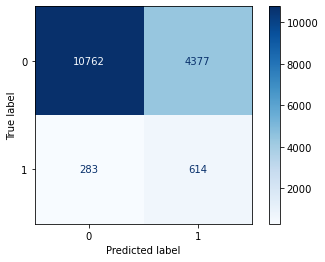

f1 : 0.2086
f3 : 0.4700
f5 : 0.5823
recall : 0.6845
negative predictive value : 0.9744
precision : 0.1230
roc_auc : 0.7672
training time : 0.44s
prediction time : 0.004s


In [48]:
m = Modelisation(X, y, pipeline.set_params(**best_params), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

### GridSearchCV avec SMOTE

In [49]:
categorical_features = list(range(len(COLUMNS_QUANT), len(X.columns)))
print(categorical_features)

over = SMOTENC(categorical_features=categorical_features,
              random_state=1234)

pipeline = Pipeline_imb([
            ('over', over),
            ('model', LogisticRegression())
            ])

cv_params = {
        "over__sampling_strategy": [0.1, 0.2, 0.4, 0.6, 0.8, 1],
        "over__k_neighbors": [3, 4, 5],
        "model__C": np.logspace(-6, 2, 30),
        "model__class_weight": [None, 'balanced', {0:1, 1:2}, {0:1, 1:4}, {0:1, 1:8}, {0:1, 1:10}, {0:1, 1:12}, {0:1, 1:14}, {0:1, 1:16.5}, {0:1, 1:32}] 
        }

scoring = {'recall': 'recall',
           'precision': 'precision',
           'f1': 'f1',
           'f3': make_scorer(fbeta_score, beta=3),
           'f5': make_scorer(fbeta_score, beta=5)
          }

print(len(ParameterGrid(cv_params)))

[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]
5400


In [50]:
# SearchCV(pipeline, cv_params, data_frac=0.1, scaling=True, scoring=scoring, n_jobs=28)

In [51]:
dico, results = restauration_CV('SMOTENC_LR_CV_Grid_5400_0.1')

model : Pipeline(steps=[('over',
                 SMOTENC(categorical_features=[13, 14, 15, 16, 17, 18, 19, 20,
                                               21, 22, 23, 24, 25, 26, 27, 28,
                                               29, 30, 31, 32, 33, 34, 35, 36,
                                               37, 38, 39, 40, 41, 42, ...],
                         random_state=1234)),
                ('model', LogisticRegression())])
model_name : SMOTENC_LR
type : GridSearchCV
len_grid : 5400
data_frac : 0.1
temps : 1day, 16min, 56s
n_jobs : 28
params : {'over__sampling_strategy': [0.1, 0.2, 0.4, 0.6, 0.8, 1], 'over__k_neighbors': [3, 4, 5], 'model__C': array([1.00000000e-06, 1.88739182e-06, 3.56224789e-06, 6.72335754e-06,
       1.26896100e-05, 2.39502662e-05, 4.52035366e-05, 8.53167852e-05,
       1.61026203e-04, 3.03919538e-04, 5.73615251e-04, 1.08263673e-03,
       2.04335972e-03, 3.85662042e-03, 7.27895384e-03, 1.37382380e-02,
       2.59294380e-02, 4.89390092e-02, 9.23670857

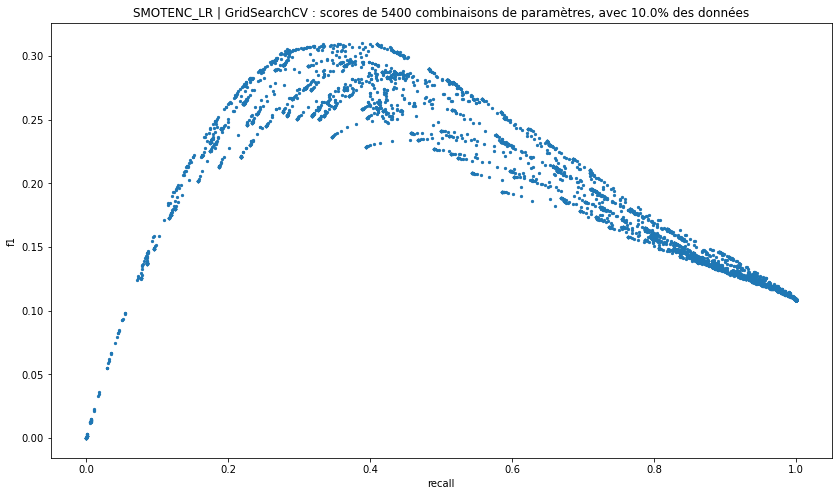

In [52]:
graph_2scores_CV(dico, results, 'recall', 'f1', s=5)

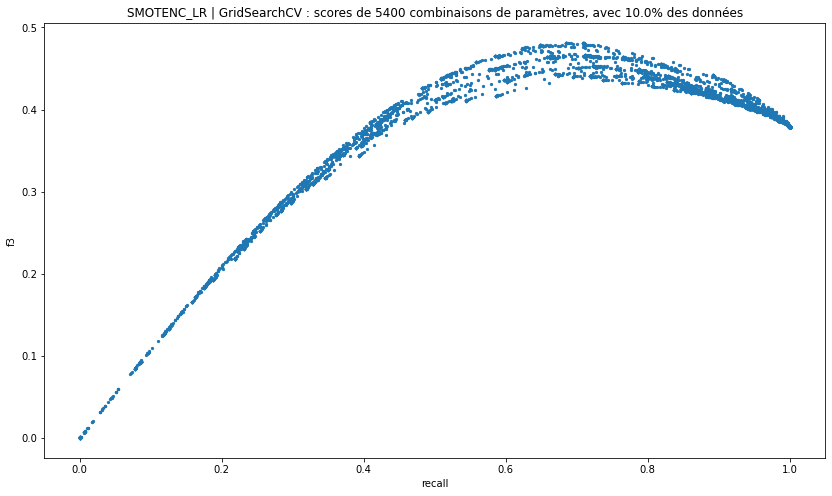

In [53]:
graph_2scores_CV(dico, results, 'recall', 'f3', s=5)

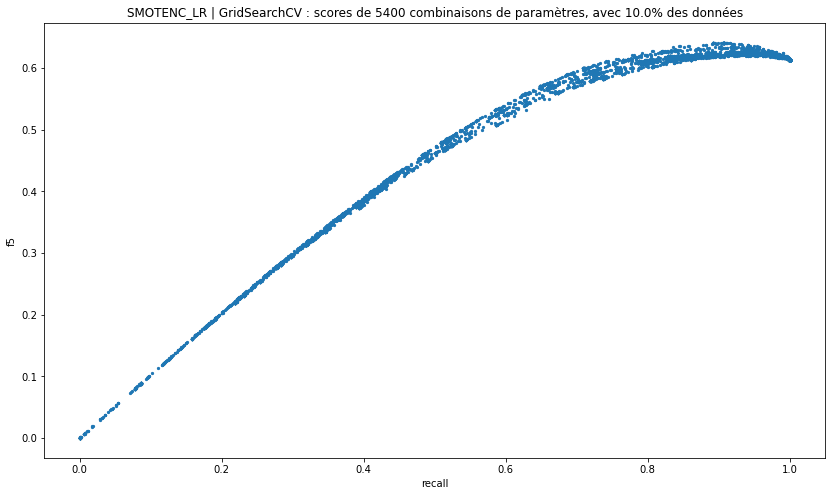

In [54]:
graph_2scores_CV(dico, results, 'recall', 'f5', s=5)

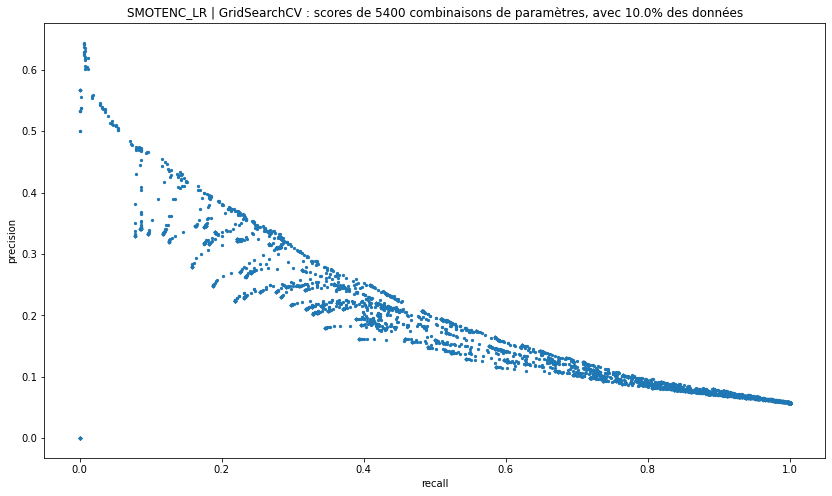

In [55]:
graph_2scores_CV(dico, results, 'recall', 'precision', s=5)

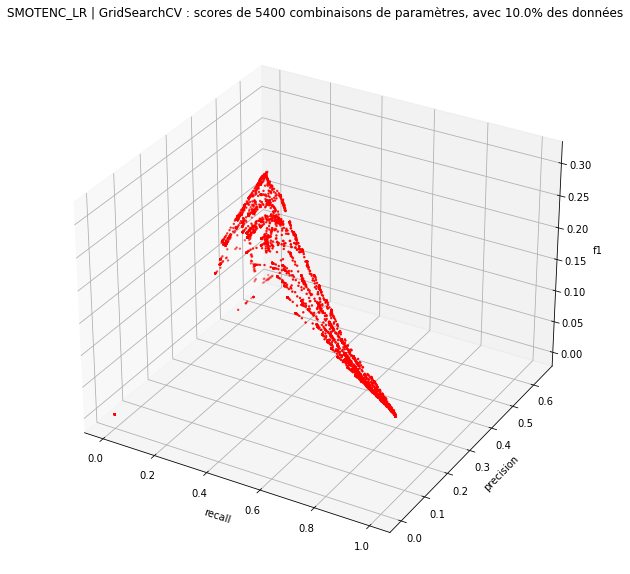

In [56]:
graph_3scores_CV(dico, results, 'recall', 'precision', 'f1', s=2)

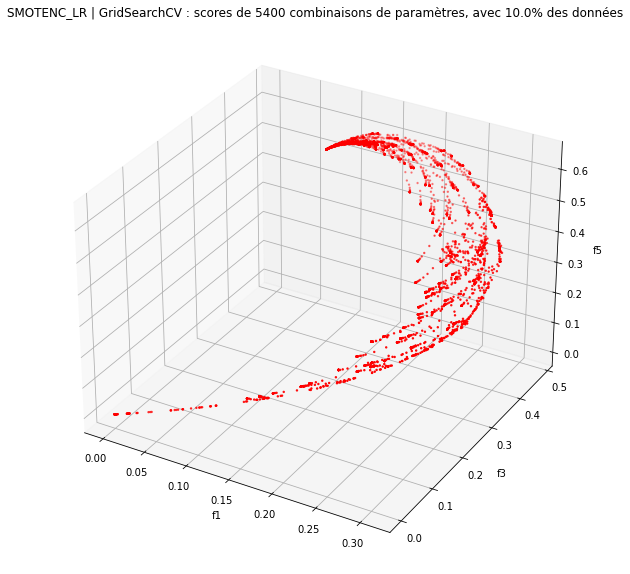

In [57]:
graph_3scores_CV(dico, results, 'f1', 'f3', 'f5', s=2)

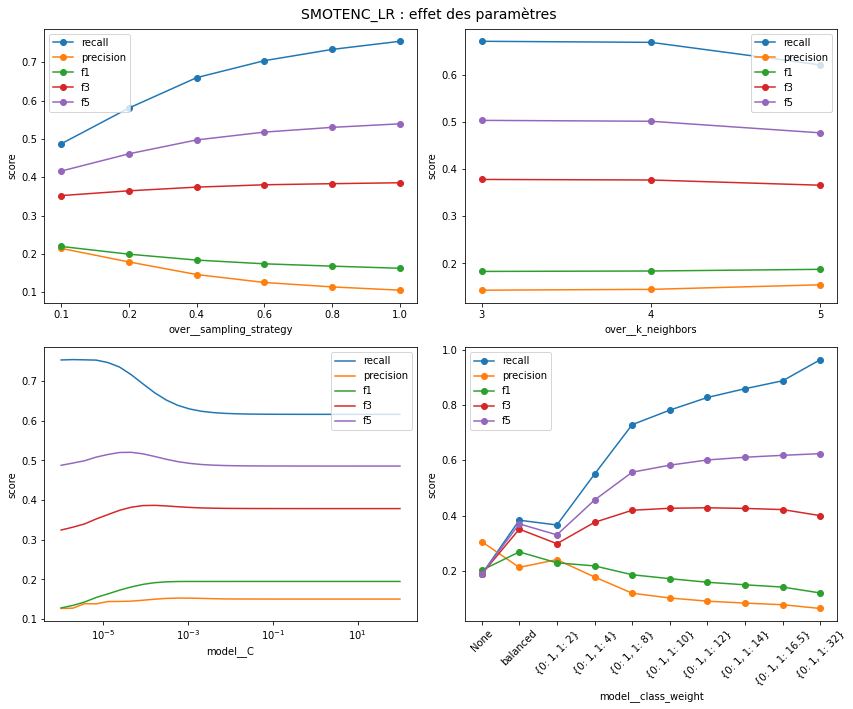

In [58]:
graph_param_CV(dico, results, xscale={'model__C': 'log'}, ncols=2, height=5, width=6)

In [59]:
best_params = best_score_CV(dico, results, 'f3')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__class_weight,param_over__k_neighbors,param_over__sampling_strategy,params,mean_test_recall,...,rank_test_precision,mean_test_f1,std_test_f1,rank_test_f1,mean_test_f3,std_test_f3,rank_test_f3,mean_test_f5,std_test_f5,rank_test_f5
2496,65.464316,2.517094,0.057922,0.002793,0.003857,"{0: 1, 1: 16.5}",5,0.1,"{'model__C': 0.0038566204211634724, 'model__cl...",0.691615,...,2235,0.217371,0.003964,1960,0.481485,0.006855,1,0.592204,0.008091,2723
3750,63.737699,3.265556,0.056865,0.0008,0.329034,"{0: 1, 1: 16.5}",4,0.1,"{'model__C': 0.3290344562312671, 'model__class...",0.709404,...,2354,0.210485,0.003844,2038,0.481236,0.006415,2,0.599985,0.007145,2575
2856,66.936174,4.301695,0.05631,0.001107,0.013738,"{0: 1, 1: 16.5}",5,0.1,"{'model__C': 0.013738237958832637, 'model__cla...",0.687276,...,2232,0.218847,0.004195,1954,0.481227,0.007172,3,0.59009,0.008451,2756
3570,69.007716,5.6793,0.056716,0.001474,0.174333,"{0: 1, 1: 16.5}",4,0.1,"{'model__C': 0.17433288221999874, 'model__clas...",0.709404,...,2364,0.210458,0.003857,2048,0.481207,0.006427,4,0.599969,0.007151,2577
3930,64.23319,1.95296,0.063355,0.011868,0.621017,"{0: 1, 1: 16.5}",4,0.1,"{'model__C': 0.6210169418915616, 'model__class...",0.709295,...,2361,0.210472,0.003808,2040,0.481182,0.006369,5,0.599906,0.007123,2581
3390,66.684352,3.241802,0.058498,0.002574,0.092367,"{0: 1, 1: 16.5}",4,0.1,"{'model__C': 0.09236708571873865, 'model__clas...",0.709512,...,2367,0.210395,0.003821,2050,0.481181,0.006364,6,0.600001,0.007087,2573
5370,64.356013,3.454986,0.058352,0.003249,100.0,"{0: 1, 1: 16.5}",4,0.1,"{'model__C': 100.0, 'model__class_weight': {0:...",0.709187,...,2355,0.210468,0.003843,2041,0.481138,0.006439,7,0.599831,0.007196,2594
4650,63.739589,2.306252,0.056144,0.001836,7.880463,"{0: 1, 1: 16.5}",4,0.1,"{'model__C': 7.880462815669905, 'model__class_...",0.709187,...,2355,0.210468,0.003843,2041,0.481138,0.006439,7,0.599831,0.007196,2594
4470,68.530756,3.190415,0.057891,0.002668,4.175319,"{0: 1, 1: 16.5}",4,0.1,"{'model__C': 4.175318936560401, 'model__class_...",0.709187,...,2355,0.210468,0.003843,2041,0.481138,0.006439,7,0.599831,0.007196,2594
5010,64.739011,2.232859,0.056901,0.001939,28.072162,"{0: 1, 1: 16.5}",4,0.1,"{'model__C': 28.072162039411758, 'model__class...",0.709187,...,2355,0.210468,0.003843,2041,0.481138,0.006439,7,0.599831,0.007196,2594


Meilleure combinaison de paramètres pour f3 :


{'model__C': 0.0038566204211634724,
 'model__class_weight': {0: 1, 1: 16.5},
 'over__k_neighbors': 5,
 'over__sampling_strategy': 0.1}

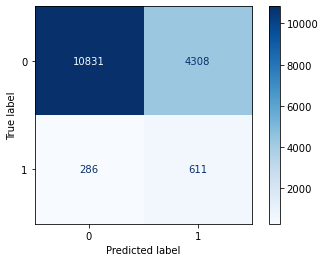

f1 : 0.2101
f3 : 0.4703
f5 : 0.5810
recall : 0.6812
negative predictive value : 0.9743
precision : 0.1242
roc_auc : 0.7614
training time : 28.759s
prediction time : 0.007s


In [60]:
m = Modelisation(X, y, pipeline.set_params(**best_params), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

In [61]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:05:20
